In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

# modeling imports
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures #Z-score variables
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering


from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, LogisticRegression # Linear Regression Model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error, accuracy_score #model evaluation
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut

# pipeline imports
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer


import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data_url = "https://raw.githubusercontent.com/karinabik1/CO2Emissions/main/Fuel%20Consumption%20Ratings%202023.csv"
data = pd.read_csv(data_url, encoding='latin-1')
data = data.drop('Comb (mpg)', axis=1) # removing column because it is redundant, we have Comb (L/100 km) already
print(data.head())

# drop missing values
data.dropna(inplace = True)
data.reset_index(inplace = True)

   Year   Make              Model  Vehicle Class  Engine Size (L)  Cylinders  \
0  2023  Acura            Integra      Full-size              1.5        4.0   
1  2023  Acura     Integra A-SPEC      Full-size              1.5        4.0   
2  2023  Acura     Integra A-SPEC      Full-size              1.5        4.0   
3  2023  Acura         MDX SH-AWD     SUV: Small              3.5        6.0   
4  2023  Acura  MDX SH-AWD Type S  SUV: Standard              3.0        6.0   

  Transmission Fuel Type  Fuel Consumption (L/100Km)  Hwy (L/100 km)  \
0          AV7         Z                         7.9             6.3   
1          AV7         Z                         8.1             6.5   
2           M6         Z                         8.9             6.5   
3         AS10         Z                        12.6             9.4   
4         AS10         Z                        13.8            11.2   

   Comb (L/100 km)  CO2 Emissions (g/km)  CO2 Rating  Smog Rating  
0              7.2

Question 1: When predicting CO2 emissions for vehicles, which predictor (engine size, cylinders, transmission, fuel type) improves the R^2 the most compared to a model with all other variables except itself?


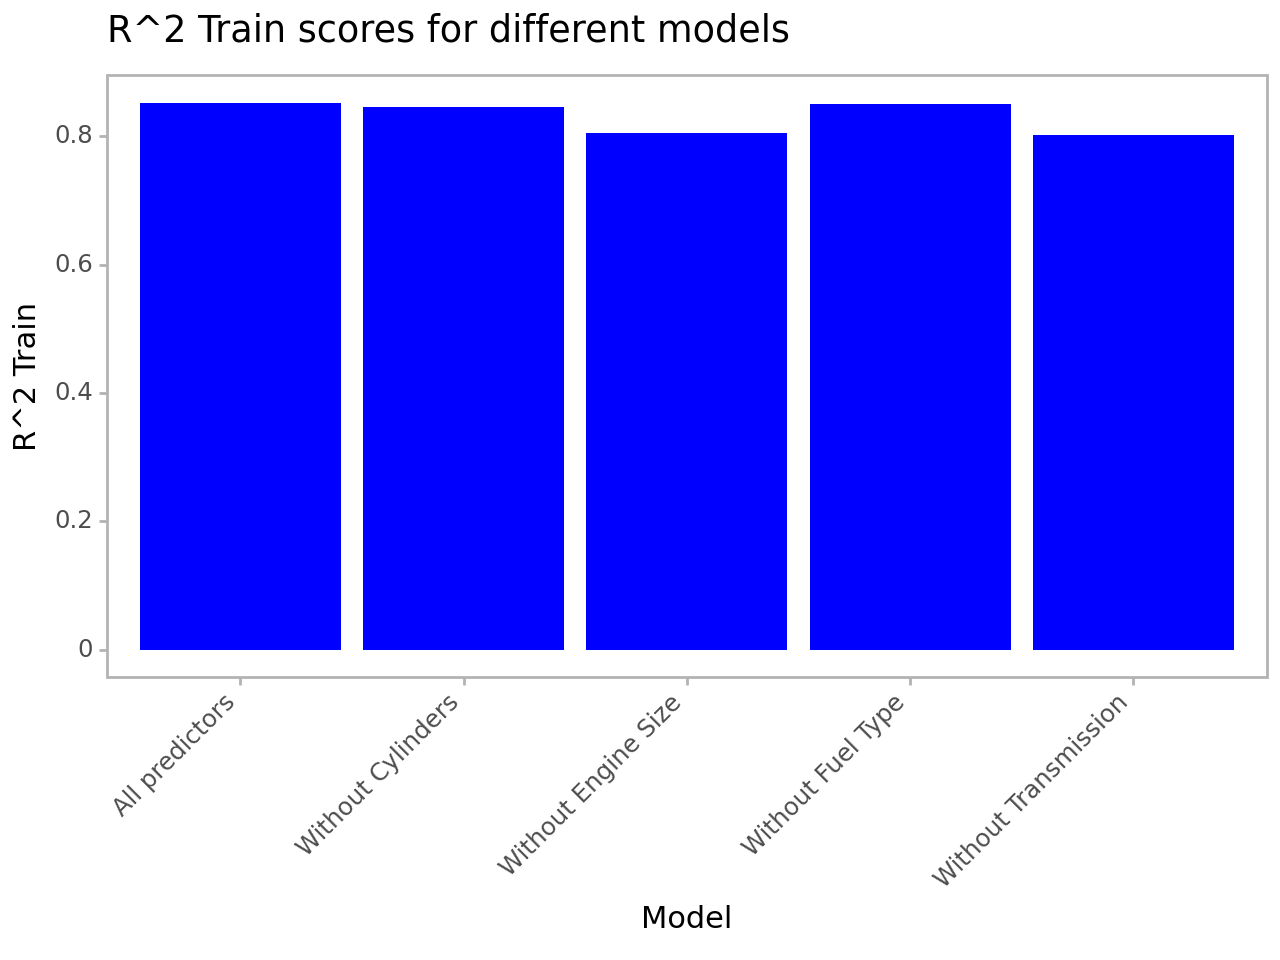

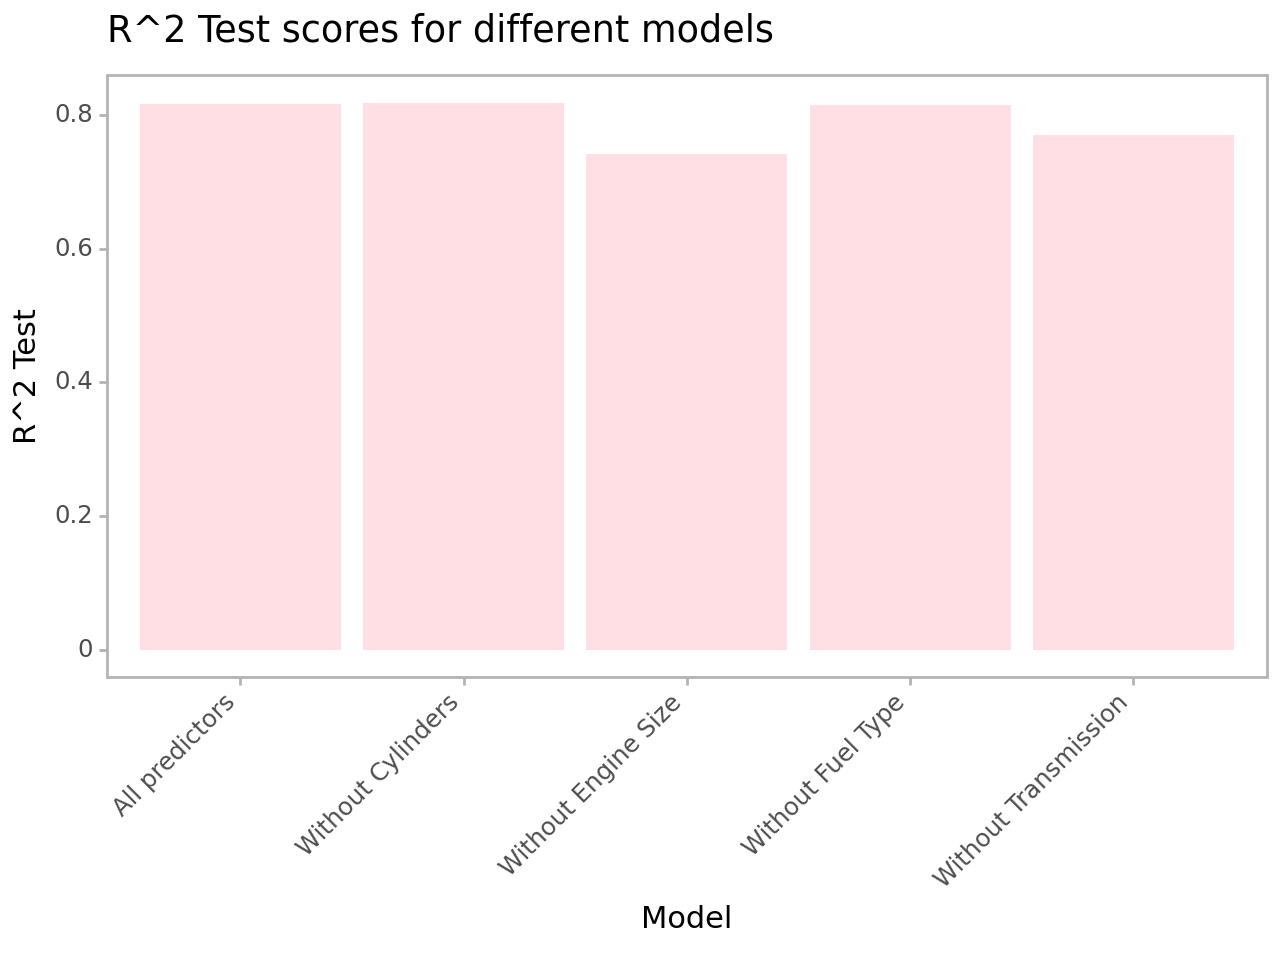


                  Model  R^2 Train  R^2 Test
0        All predictors   0.852190  0.816510
1   Without Engine Size   0.805065  0.742378
2     Without Cylinders   0.845315  0.818491
3  Without Transmission   0.801918  0.770642
4     Without Fuel Type   0.850316  0.815277
The predictor that improves the model the most when removed is: Without Cylinders
R^2 Test Improvement: 0.001980329330531938


In [ ]:
# Set up X and y
predictors = ["Engine Size (L)", "Cylinders", "Transmission", "Fuel Type"]
X = data[predictors]
y = data["CO2 Emissions (g/km)"]

# Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
preprocess = make_column_transformer(
    (OneHotEncoder(), ['Engine Size (L)', 'Cylinders', 'Transmission', 'Fuel Type']),
    remainder='passthrough'
)

# Linear Regression pipeline with all predictors
lin_pipe_all = Pipeline([
    ('pre', preprocess),
    ('model', LinearRegression())
])

# Fit the model with all predictors
lin_pipe_all.fit(X_train, y_train)

# Linear Regression pipeline without 'Engine Size (L)'
lin_pipe_without_engine_size = Pipeline([
    ('pre', make_column_transformer(
        (OneHotEncoder(), ['Cylinders', 'Transmission', 'Fuel Type']),
        remainder='passthrough'
    )),
    ('model', LinearRegression())
])

# Fit the model without 'Engine Size (L)'
lin_pipe_without_engine_size.fit(X_train.drop(columns=['Engine Size (L)']), y_train)

# Linear Regression pipeline without 'Cylinders'
lin_pipe_without_cylinders = Pipeline([
    ('pre', make_column_transformer(
        (OneHotEncoder(), ['Engine Size (L)', 'Transmission', 'Fuel Type']),
        remainder='passthrough'
    )),
    ('model', LinearRegression())
])

# Fit the model without 'Cylinders'
lin_pipe_without_cylinders.fit(X_train.drop(columns=['Cylinders']), y_train)

# Linear Regression pipeline without 'Transmission'
lin_pipe_without_transmission = Pipeline([
    ('pre', make_column_transformer(
        (OneHotEncoder(), ['Engine Size (L)', 'Cylinders', 'Fuel Type']),
        remainder='passthrough'
    )),
    ('model', LinearRegression())
])

# Fit the model without 'Transmission'
lin_pipe_without_transmission.fit(X_train.drop(columns=['Transmission']), y_train)

# Linear Regression pipeline without 'Fuel Type'
lin_pipe_without_fuel_type = Pipeline([
    ('pre', make_column_transformer(
        (OneHotEncoder(), ['Engine Size (L)', 'Cylinders', 'Transmission']),
        remainder='passthrough'
    )),
    ('model', LinearRegression())
])

# Fit the model without 'Fuel Type'
lin_pipe_without_fuel_type.fit(X_train.drop(columns=['Fuel Type']), y_train)

# Predictions
y_pred_train_all = lin_pipe_all.predict(X_train)
y_pred_test_all = lin_pipe_all.predict(X_test)

y_pred_train_without_engine_size = lin_pipe_without_engine_size.predict(X_train.drop(columns=['Engine Size (L)']))
y_pred_test_without_engine_size = lin_pipe_without_engine_size.predict(X_test.drop(columns=['Engine Size (L)']))

y_pred_train_without_cylinders = lin_pipe_without_cylinders.predict(X_train.drop(columns=['Cylinders']))
y_pred_test_without_cylinders = lin_pipe_without_cylinders.predict(X_test.drop(columns=['Cylinders']))

y_pred_train_without_transmission = lin_pipe_without_transmission.predict(X_train.drop(columns=['Transmission']))
y_pred_test_without_transmission = lin_pipe_without_transmission.predict(X_test.drop(columns=['Transmission']))

y_pred_train_without_fuel_type = lin_pipe_without_fuel_type.predict(X_train.drop(columns=['Fuel Type']))
y_pred_test_without_fuel_type = lin_pipe_without_fuel_type.predict(X_test.drop(columns=['Fuel Type']))

r2_train_all = lin_pipe_all.score(X_train, y_train)
r2_test_all = lin_pipe_all.score(X_test, y_test)

r2_train_without_engine_size = lin_pipe_without_engine_size.score(X_train.drop(columns=['Engine Size (L)']), y_train)
r2_test_without_engine_size = lin_pipe_without_engine_size.score(X_test.drop(columns=['Engine Size (L)']), y_test)

r2_train_without_cylinders = lin_pipe_without_cylinders.score(X_train.drop(columns=['Cylinders']), y_train)
r2_test_without_cylinders = lin_pipe_without_cylinders.score(X_test.drop(columns=['Cylinders']), y_test)

r2_train_without_transmission = lin_pipe_without_transmission.score(X_train.drop(columns=['Transmission']), y_train)
r2_test_without_transmission = lin_pipe_without_transmission.score(X_test.drop(columns=['Transmission']), y_test)

r2_train_without_fuel_type = lin_pipe_without_fuel_type.score(X_train.drop(columns=['Fuel Type']), y_train)
r2_test_without_fuel_type = lin_pipe_without_fuel_type.score(X_test.drop(columns=['Fuel Type']), y_test)

df = pd.DataFrame({
    'Model': ['All predictors', 'Without Engine Size', 'Without Cylinders', 'Without Transmission', 'Without Fuel Type'],
    'R^2 Train': [r2_train_all, r2_train_without_engine_size, r2_train_without_cylinders, r2_train_without_transmission, r2_train_without_fuel_type],
    'R^2 Test': [r2_test_all, r2_test_without_engine_size, r2_test_without_cylinders, r2_test_without_transmission, r2_test_without_fuel_type]
})

# Plot bar chart for R^2 Train using ggplot with adjusted x-axis label width
bar_plot_train = (
    ggplot(df, aes(x='Model')) +
    geom_col(aes(y='R^2 Train'), fill='blue') +
    labs(x='Model', y='R^2 Train', title='R^2 Train scores for different models') +
    theme_light() +
    theme(
        panel_grid_major_x=element_blank(),
        panel_grid_major_y=element_blank(),
        panel_grid_minor_y=element_blank(),
        axis_text_x=element_text(angle=45, hjust=1)  # Rotate labels by 45 degrees and align them to the right
    )
)

# Plot bar chart for R^2 Test using ggplot with adjusted x-axis label width
bar_plot_test = (
    ggplot(df, aes(x='Model')) +
    geom_col(aes(y='R^2 Test'), fill='pink', alpha=0.5) +  # Pink with 50% transparency
    labs(x='Model', y='R^2 Test', title='R^2 Test scores for different models') +
    theme_light() +
    theme(
        panel_grid_major_x=element_blank(),
        panel_grid_major_y=element_blank(),
        panel_grid_minor_y=element_blank(),
        axis_text_x=element_text(angle=45, hjust=1)  # Rotate labels by 45 degrees and align them to the right
    )
)

# Display the bar charts
print(bar_plot_train)
print(bar_plot_test)

print(df)

# Calculate the improvement in R^2 scores when each predictor is removed
improvement_r2 = df['R^2 Test'] - df.at[0, 'R^2 Test']  # Assuming the first row corresponds to the model with all predictors

# Identify the predictor with the largest improvement
best_predictor_index = improvement_r2.idxmax()
best_predictor = df.at[best_predictor_index, 'Model']

# Analyze the impact of the best predictor's removal
print(f"The predictor that improves the model the most when removed is: {best_predictor}")
print(f"R^2 Test Improvement: {improvement_r2.max()}")




Question 2: When considering CO2 emissions, what clusters emerge, and what characterizes those clusters?


0.4318017037488516


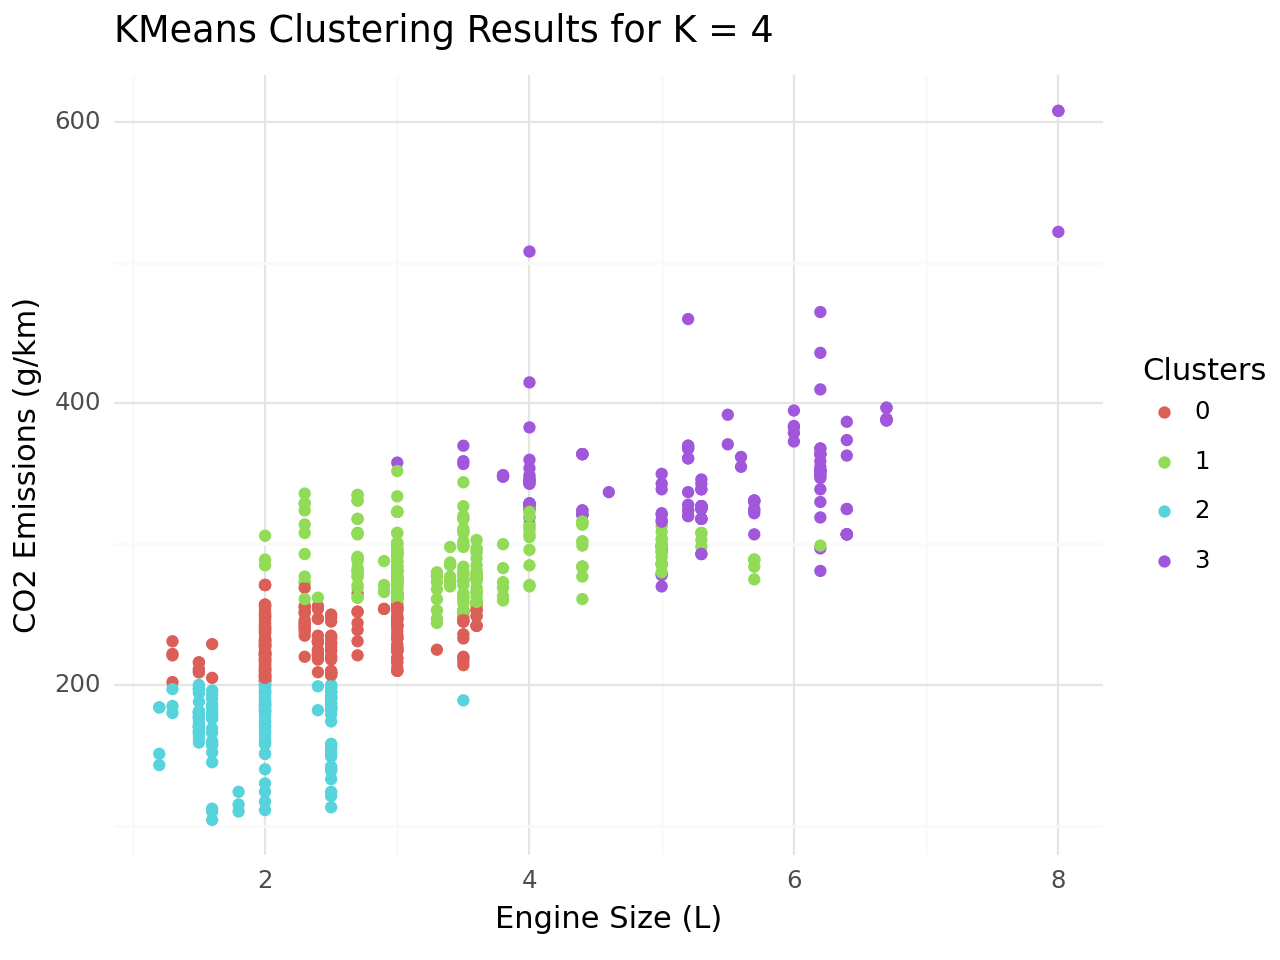

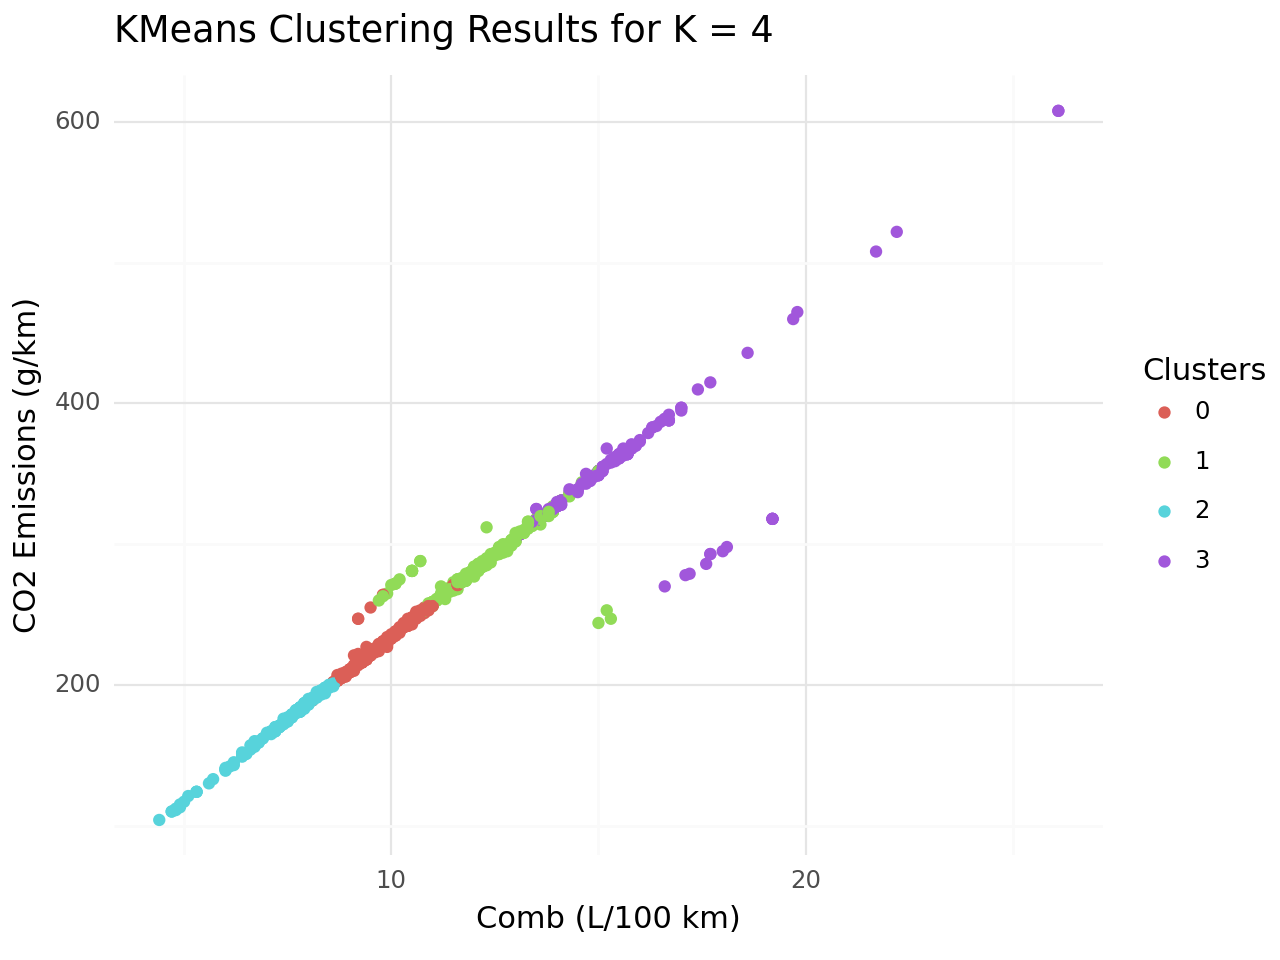


   clusters  Engine Size (L)  Cylinders  Fuel Consumption (L/100Km)  \
0         0         2.357836   4.485075                   10.973134   
1         1         3.449606   6.165354                   13.661417   
2         2         1.964596   3.888199                    8.048447   
3         3         5.318667   8.626667                   17.658667   

   Hwy (L/100 km)  Comb (L/100 km)  CO2 Emissions (g/km)  CO2 Rating  \
0        8.334701         9.785448            229.858209    4.970149   
1       10.310236        12.151969            285.708661    3.948819   
2        6.585714         7.393789            173.180124    6.360248   
3       12.525333        15.352000            349.466667    2.720000   

   Smog Rating  
0     5.604478  
1     4.980315  
2     6.627329  
3     3.520000  


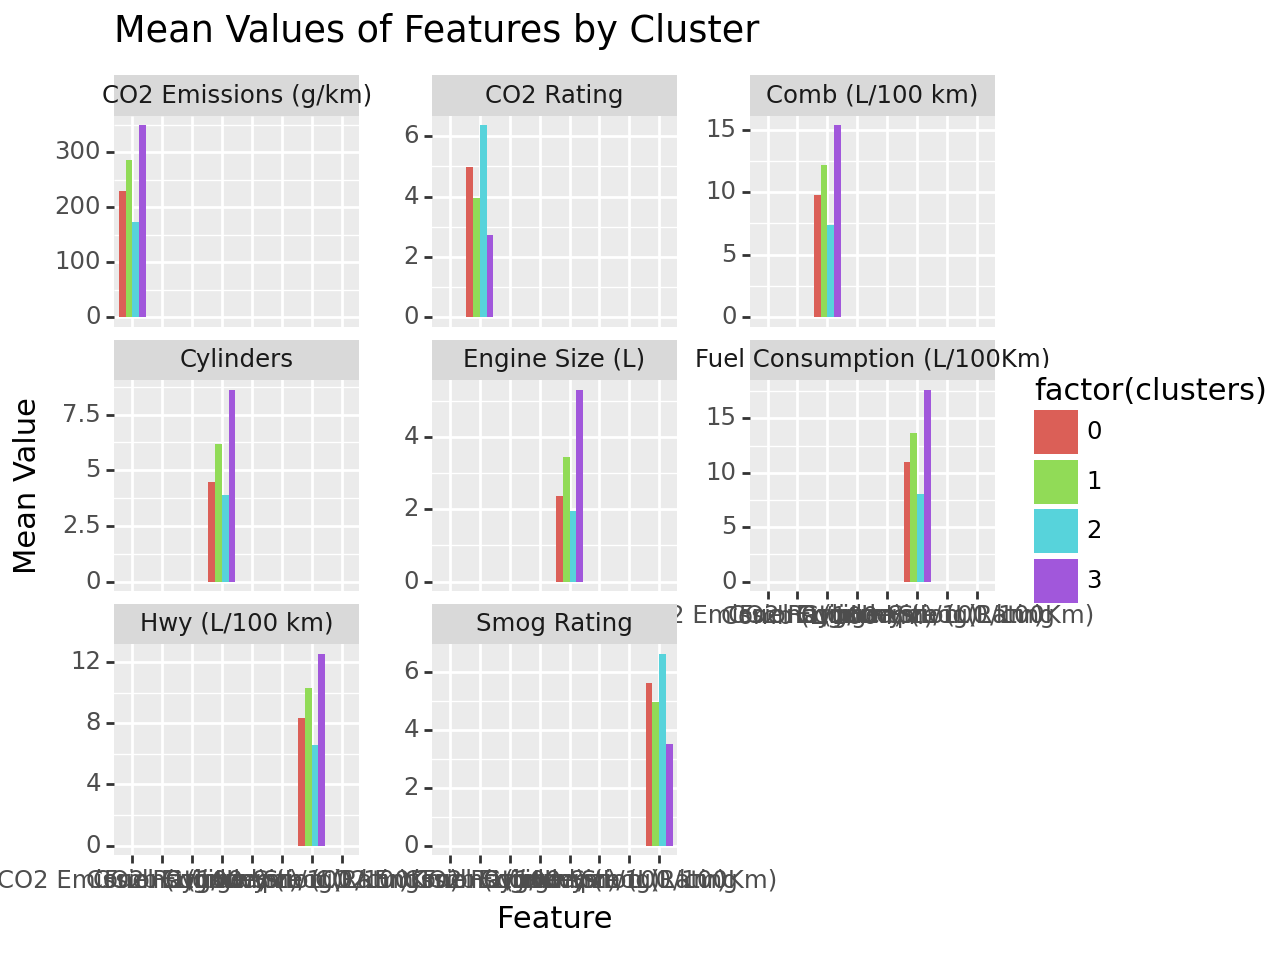

In [ ]:
# all the continuous variables
contin_predictors = ["Engine Size (L)", "Cylinders", "Fuel Consumption (L/100Km)", "Hwy (L/100 km)", "Comb (L/100 km)", "CO2 Emissions (g/km)", "CO2 Rating", "Smog Rating"]

X2 = data[contin_predictors]

# scale continuous variables
z = make_column_transformer((StandardScaler(), contin_predictors),
                            remainder = "passthrough")

km = KMeans(n_clusters = 4)
pipe = Pipeline([("z", z), ("clust", km)])

labels = pipe.fit_predict(X2)

print(silhouette_score(X2, pipe.predict(X2)))
X2["clusters"] = labels

print(ggplot(X2, aes(x = "Engine Size (L)", y = "CO2 Emissions (g/km)", color = "factor(clusters)" )) +
      geom_point() + theme_minimal() +
     labs(x = "Engine Size (L)", y = "CO2 Emissions (g/km)", title = "KMeans Clustering Results for K = 4",
         color = "Clusters"))

print(ggplot(X2, aes(x = "Comb (L/100 km)", y = "CO2 Emissions (g/km)", color = "factor(clusters)" )) +
      geom_point() + theme_minimal() +
     labs(x = "Comb (L/100 km)", y = "CO2 Emissions (g/km)", title = "KMeans Clustering Results for K = 4",
         color = "Clusters"))

# cluster summary:
# 1. with groupby
cluster_summary = X2.groupby("clusters").mean().reset_index()
print(cluster_summary)

# 2. with ggplot
cluster_summary_melted = pd.melt(cluster_summary, id_vars=["clusters"], var_name="Feature", value_name="Mean Value")
bar_plot = (ggplot(cluster_summary_melted, aes(x="Feature", y="Mean Value", fill="factor(clusters)")) +
            geom_bar(stat="identity", position="dodge") +
            facet_wrap("~Feature", scales="free_y") +
            ggtitle("Mean Values of Features by Cluster"))

print(bar_plot)

Question 3: How does engine size (L) correlate with both fuel consumption (L/100km) and CO2 emissions (g/km)? Are there any trends indicating larger engines consume more fuel and emit more CO2?


In [ ]:
#set up X and y
contin = ["Fuel Consumption (L/100Km)"]

X3 = data[contin]
y3 = data["Engine Size (L)"]

# validation
X_train, X_test, y_train, y_test = train_test_split(X3,y3, test_size = 0.2, random_state = 42)

# z score
preprocess = make_column_transformer((StandardScaler(), contin),
                                                                    remainder = "passthrough")

lin_pipe = Pipeline([('pre', preprocess),
 ('model', LinearRegression())
 ])

lin_pipe.fit(X_train,y_train)

# predict
y_pred_train_lin = lin_pipe.predict(X_train)
y_pred_test_lin = lin_pipe.predict(X_test)

#asses
print("Linear Regression: ")
print("Train MSE : ", mean_squared_error(y_train,y_pred_train_lin))
print("Train MAE : ", mean_absolute_error(y_train,y_pred_train_lin))
print("Train MAPE: ", mean_absolute_percentage_error(y_train,y_pred_train_lin))
print("Train R2  : ", r2_score(y_train,y_pred_train_lin))

print("Test MSE : ", mean_squared_error(y_test,y_pred_test_lin))
print("Test MAE : ", mean_absolute_error(y_test,y_pred_test_lin))
print("Test MAPE: ", mean_absolute_percentage_error(y_test,y_pred_test_lin))
print("Test R2  : ", r2_score(y_test,y_pred_test_lin))


Linear Regression: 
Train MSE :  0.6031728053308356
Train MAE :  0.6218774592245672
Train MAPE:  0.2113372869065346
Train R2  :  0.681467904731627
Test MSE :  0.5034032995420972
Test MAE :  0.5772602128299525
Test MAPE:  0.21747356637217058
Test R2  :  0.6684936179779926


In [ ]:
#set up X and y
contin = ["CO2 Emissions (g/km)"]

X3 = data[contin]
y3 = data["Engine Size (L)"]

# validation
X_train, X_test, y_train, y_test = train_test_split(X3,y3, test_size = 0.2, random_state = 42)

# z score
preprocess = make_column_transformer((StandardScaler(), contin),
                                                                    remainder = "passthrough")

lin_pipe = Pipeline([('pre', preprocess),
 ('model', LinearRegression())
 ])

lin_pipe.fit(X_train,y_train)

# predict
y_pred_train_lin = lin_pipe.predict(X_train)
y_pred_test_lin = lin_pipe.predict(X_test)

#asses
print("Linear Regression: ")
print("Train MSE : ", mean_squared_error(y_train,y_pred_train_lin))
print("Train MAE : ", mean_absolute_error(y_train,y_pred_train_lin))
print("Train MAPE: ", mean_absolute_percentage_error(y_train,y_pred_train_lin))
print("Train R2  : ", r2_score(y_train,y_pred_train_lin))

print("Test MSE : ", mean_squared_error(y_test,y_pred_test_lin))
print("Test MAE : ", mean_absolute_error(y_test,y_pred_test_lin))
print("Test MAPE: ", mean_absolute_percentage_error(y_test,y_pred_test_lin))
print("Test R2  : ", r2_score(y_test,y_pred_test_lin))

Linear Regression: 
Train MSE :  0.6841407860947002
Train MAE :  0.6527741778520709
Train MAPE:  0.22014662121923148
Train R2  :  0.6387091789826818
Test MSE :  0.5931393656222516
Test MAE :  0.6143951126883053
Test MAPE:  0.225761167677162
Test R2  :  0.6093996894515425


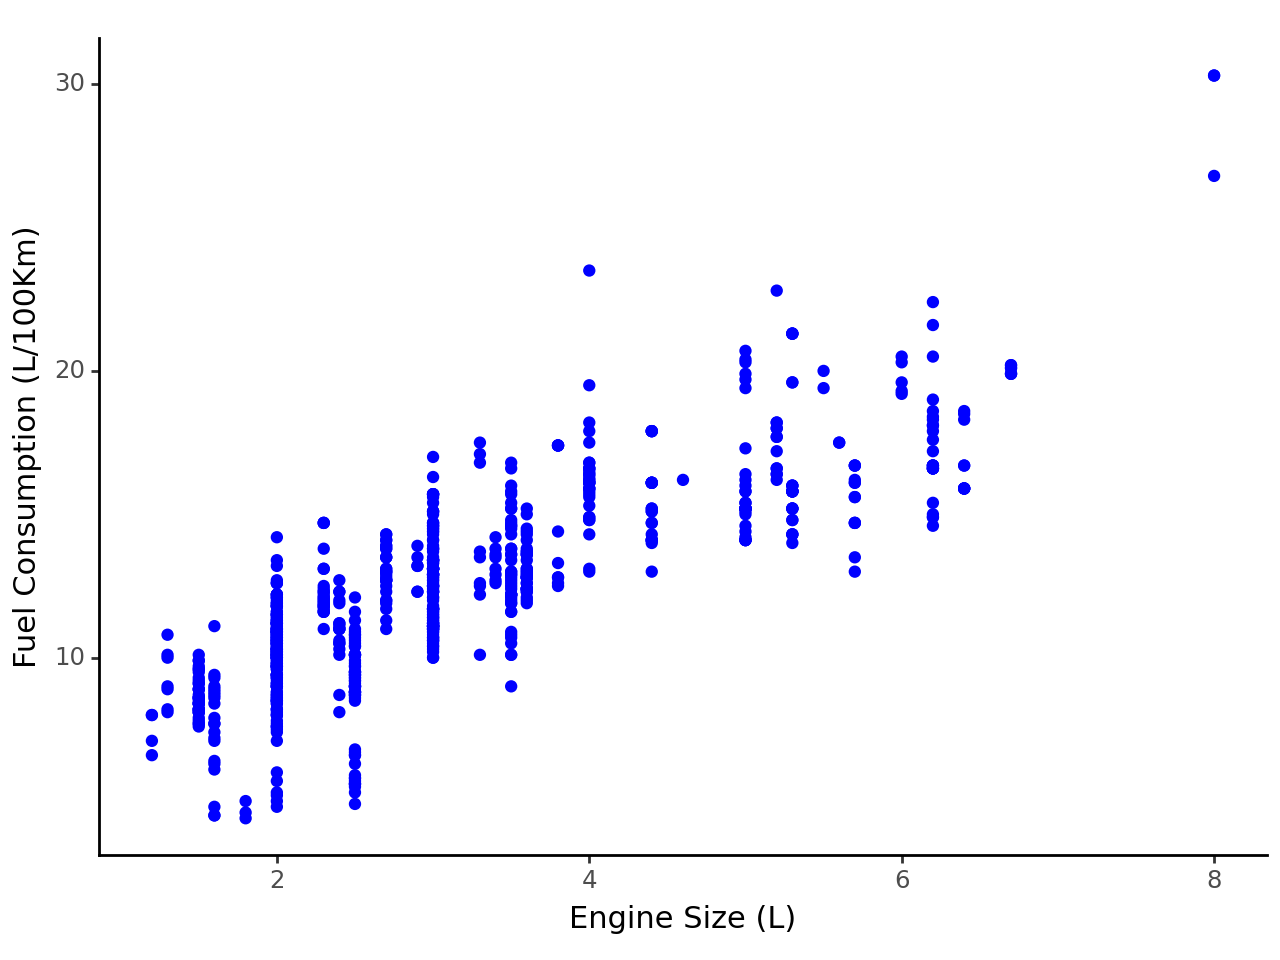

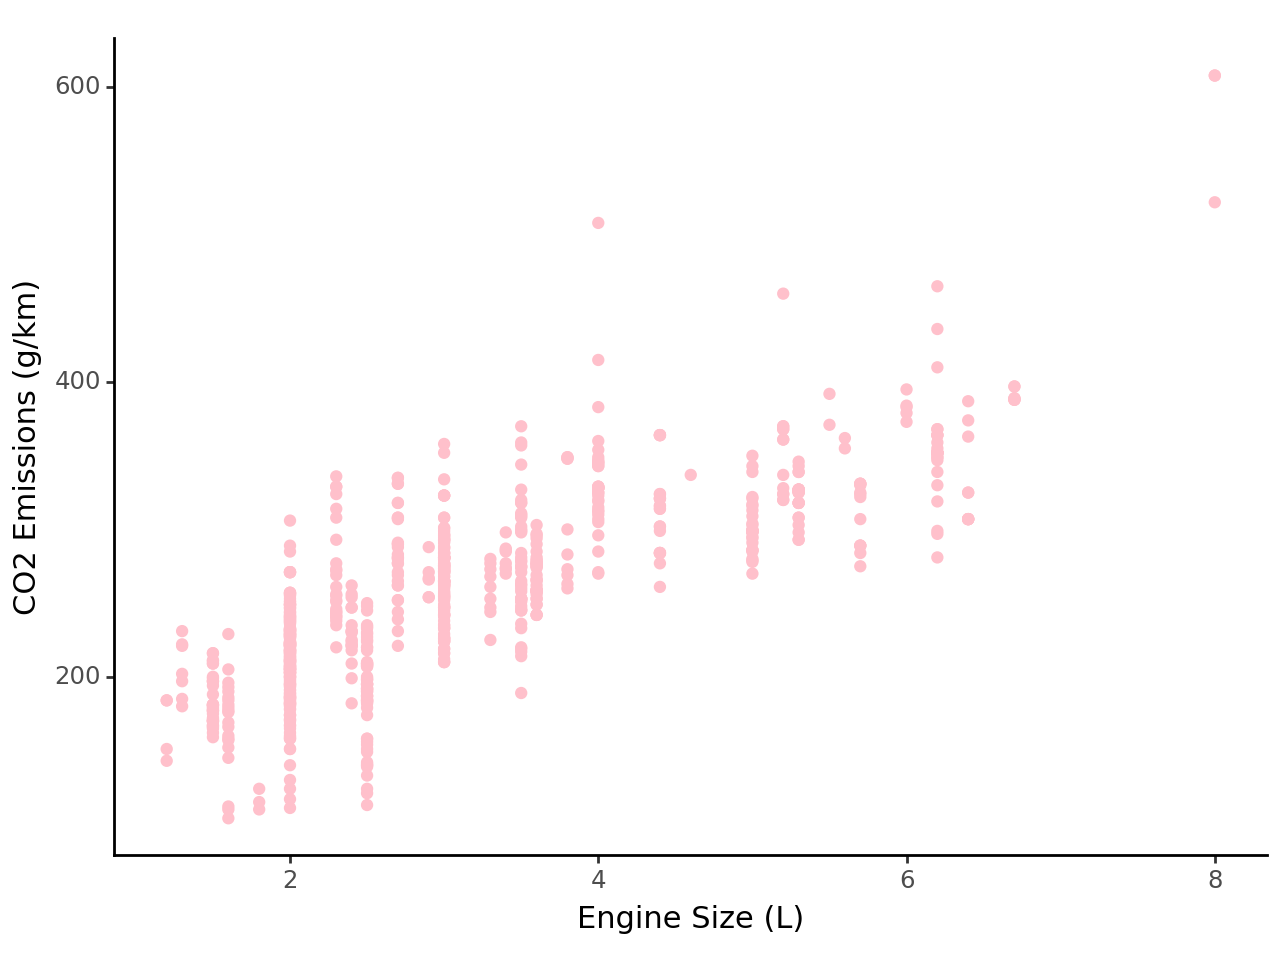

In [ ]:
print(ggplot(data, aes(y = "Fuel Consumption (L/100Km)", x = "Engine Size (L)"))+ geom_point(color = "blue")+ theme_classic())
print(ggplot(data, aes(y = "CO2 Emissions (g/km)", x = "Engine Size (L)"))+ geom_point(color = "pink")+ theme_classic())

Question 4: Can we predict a vehicle’s fuel consumption (L/100km) based on its transmission type, fuel type, and engine size (L) using a supervised learning regression model?


Linear Regression: 
Train MSE :  1.4290734972121826
Train MAE :  0.8932933840416929
Train MAPE:  1.4290734972121826
Train R2  :  0.8861435477604499
Test MSE :  1.239354627613179
Test MAE :  0.8504851250764204
Test MAPE:  1.239354627613179
Test R2  :  0.8650331759016531


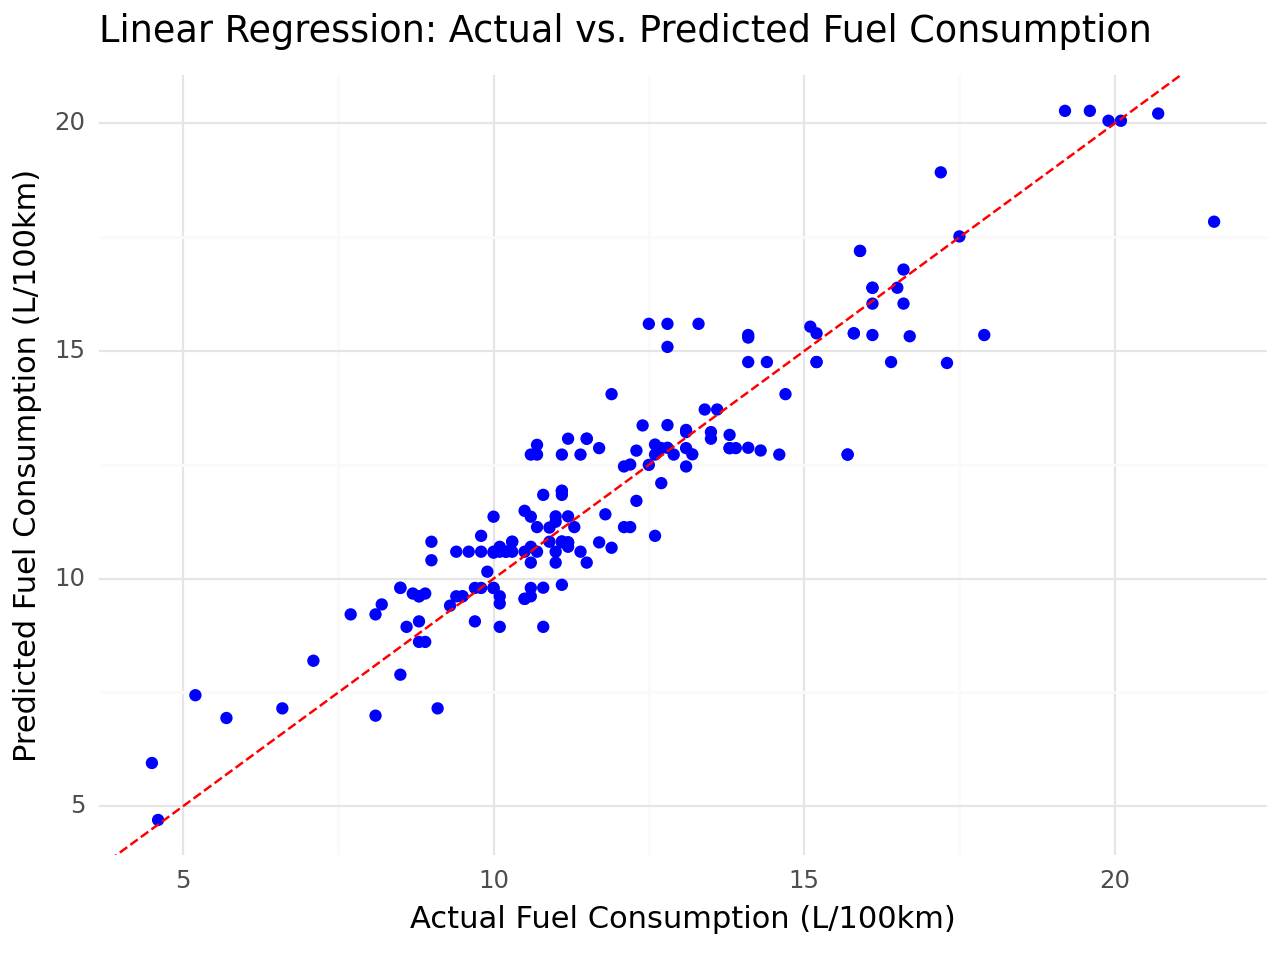

In [ ]:
# Set up X and y
predictors = ["Engine Size (L)", "Transmission", "Fuel Type"]
X4 = data[predictors]
y4 = data["Fuel Consumption (L/100Km)"]

# validation
X_train, X_test, y_train, y_test = train_test_split(X4, y4, test_size = 0.2, random_state = 42)

# z score
preprocess = make_column_transformer((OneHotEncoder(), ['Engine Size (L)', 'Transmission', 'Fuel Type']),
                            remainder = 'passthrough')

lin_pipe = Pipeline([('pre', preprocess),
 ('model', LinearRegression())
 ])

# fit
lin_pipe.fit(X_train,y_train)


# predict
y_pred_train_lin = lin_pipe.predict(X_train)
y_pred_test_lin = lin_pipe.predict(X_test)


#asses
print("Linear Regression: ")
print("Train MSE : ", mean_squared_error(y_train,y_pred_train_lin))
print("Train MAE : ", mean_absolute_error(y_train,y_pred_train_lin))
print("Train MAPE: ", mean_squared_error(y_train,y_pred_train_lin))
print("Train R2  : ", r2_score(y_train,y_pred_train_lin))

print("Test MSE : ", mean_squared_error(y_test,y_pred_test_lin))
print("Test MAE : ", mean_absolute_error(y_test,y_pred_test_lin))
print("Test MAPE: ", mean_squared_error(y_test,y_pred_test_lin))
print("Test R2  : ", r2_score(y_test,y_pred_test_lin))

# Convert test data and predictions into a DataFrame
data_lin = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test_lin})

# Scatterplot for linear regression
scatter_lin = (
    ggplot(data_lin, aes(x='Actual', y='Predicted')) +
    geom_point(color='blue') +
    geom_abline(intercept=0, slope=1, linetype='dashed', color='red') +
    labs(x='Actual Fuel Consumption (L/100km)', y='Predicted Fuel Consumption (L/100km)',
         title='Linear Regression: Actual vs. Predicted Fuel Consumption') +
    theme_minimal()
)

# Display the scatterplots
print(scatter_lin)

Question 5:  How does the CO2 rating of a vehicle correlate with its fuel consumption (L/100km) and engine size (L)? Does a higher CO2 rating generally indicate better fuel efficiency and smaller engine size?


                            CO2 Rating  Fuel Consumption (L/100Km)  \
CO2 Rating                    1.000000                   -0.920071   
Fuel Consumption (L/100Km)   -0.920071                    1.000000   
Engine Size (L)              -0.751129                    0.825360   

                            Engine Size (L)  
CO2 Rating                        -0.751129  
Fuel Consumption (L/100Km)         0.825360  
Engine Size (L)                    1.000000  


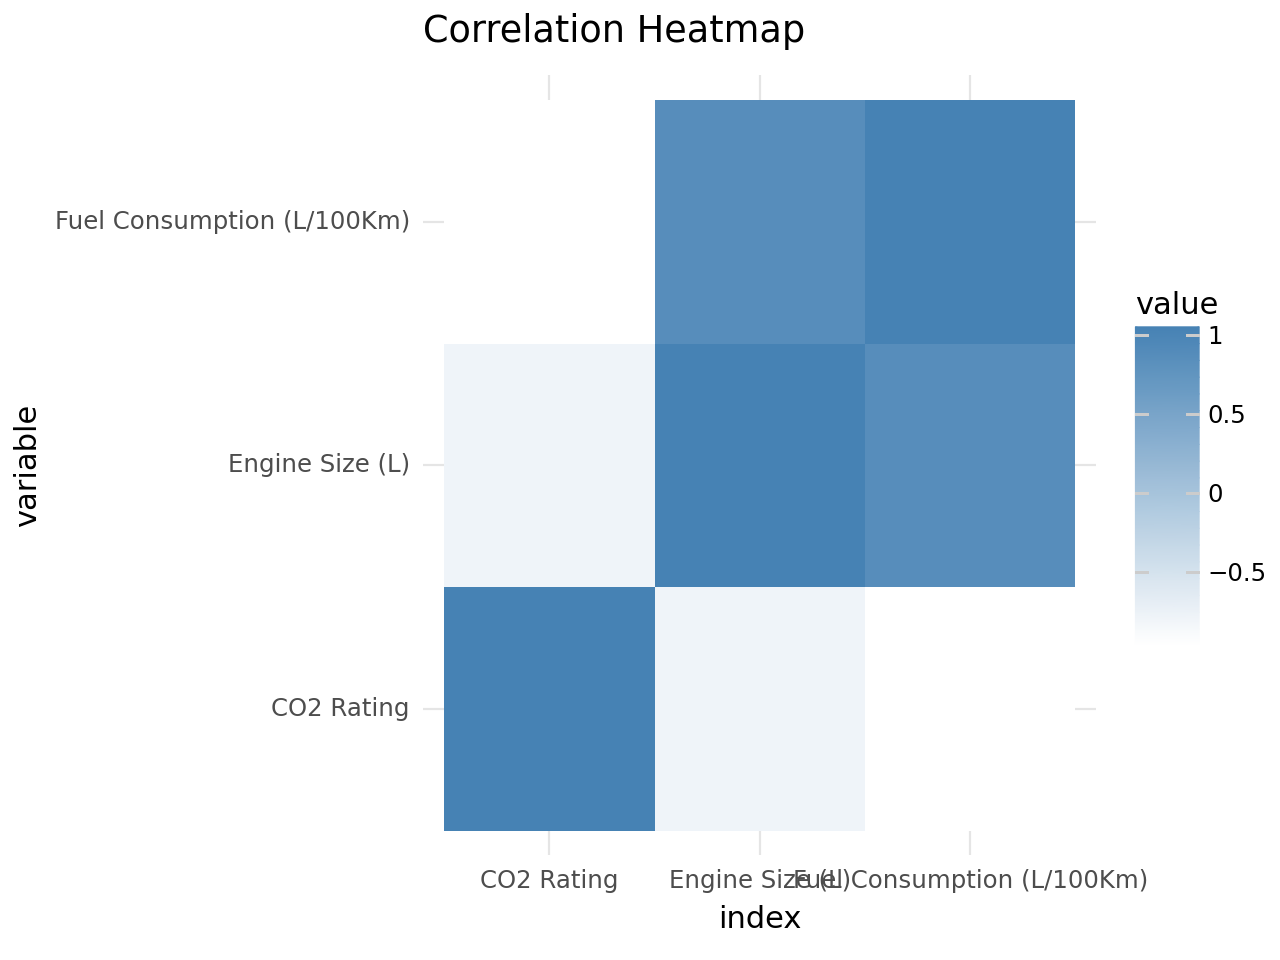

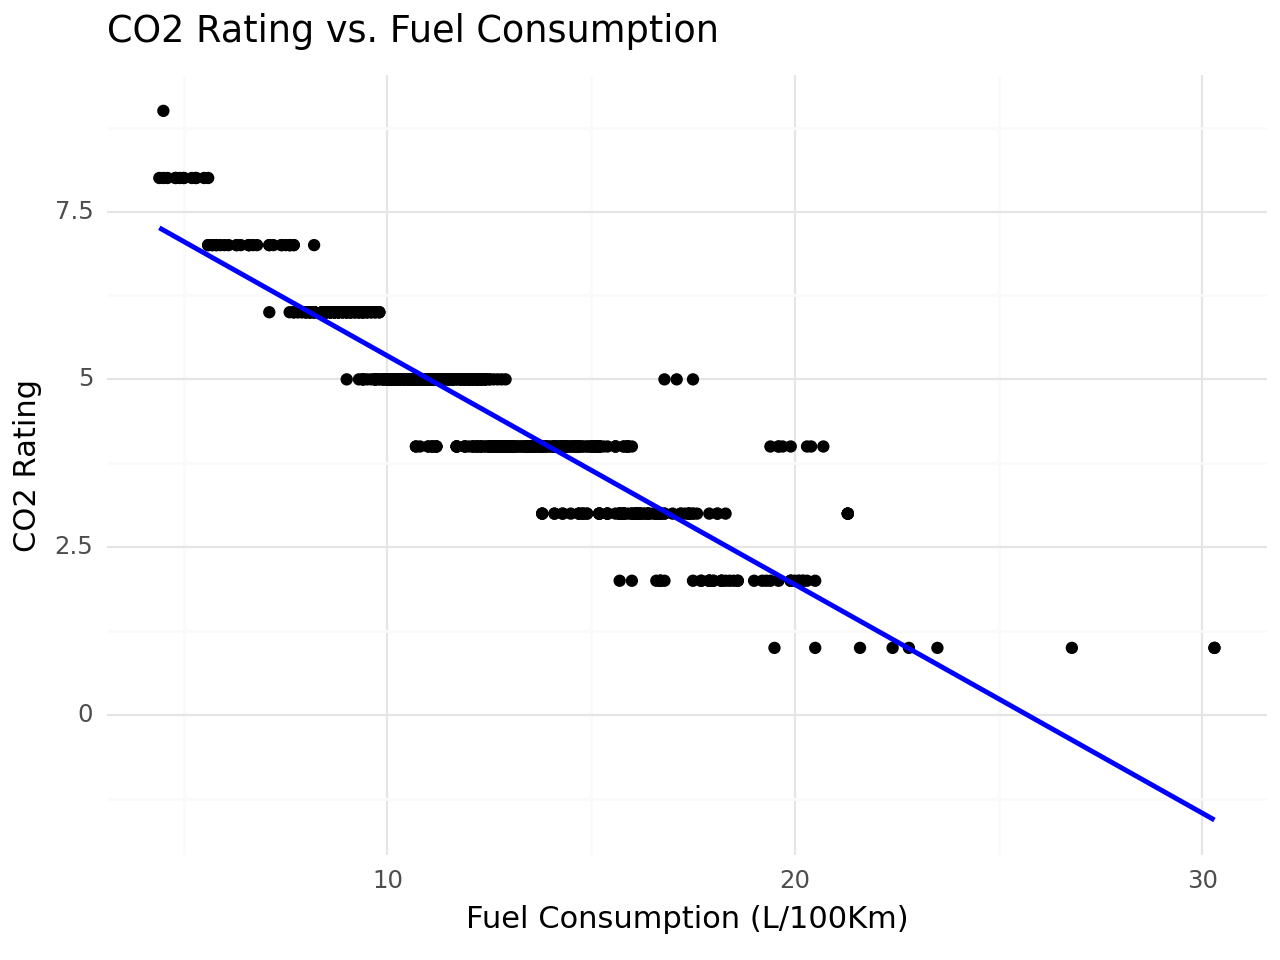

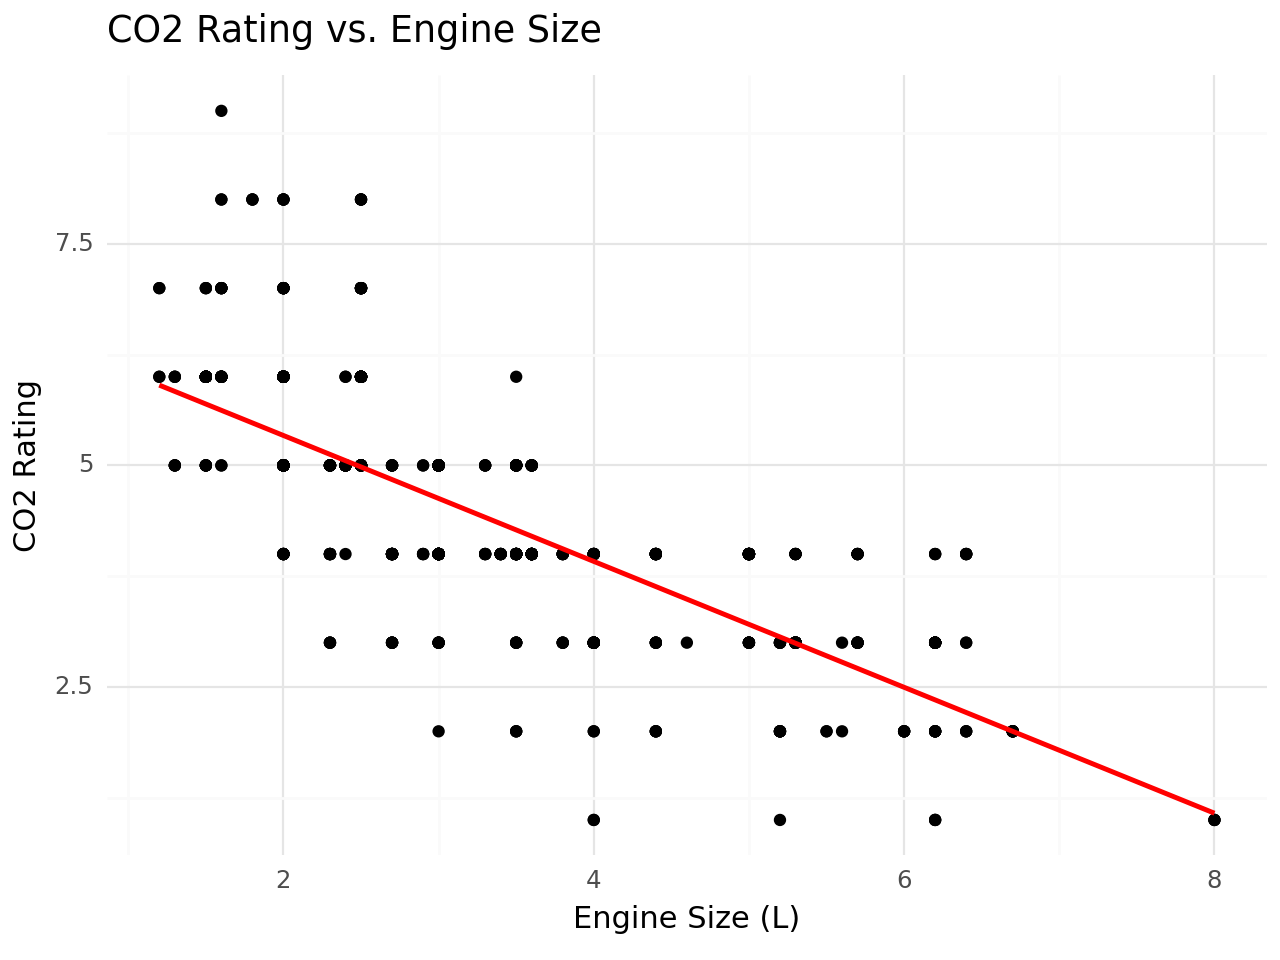

In [ ]:
# predictors
predictors = ["CO2 Rating", "Fuel Consumption (L/100Km)", "Engine Size (L)"]
X5 = data[predictors]

# calculate correlation coefficients
correlation_matrix = X5[["CO2 Rating", "Fuel Consumption (L/100Km)", "Engine Size (L)"]].corr()

# print correlation matrix
print(correlation_matrix)

# heatmap using ggplot
correlation_matrix_reset = correlation_matrix.reset_index()

correlation_matrix_melted = correlation_matrix_reset.melt(id_vars="index")

print(ggplot(correlation_matrix_melted, aes(x="index", y="variable", fill="value")) +
    geom_tile() +
    scale_fill_gradient(low="white", high="steelblue") +
    theme_minimal() +
    labs(title="Correlation Heatmap"))

# scatterplots using ggplot
print(ggplot(X5, aes(x="Fuel Consumption (L/100Km)", y="CO2 Rating")) +
    geom_point() +
    geom_smooth(method="lm", se=False, color="blue") +
    theme_minimal() +
    labs(x="Fuel Consumption (L/100Km)", y="CO2 Rating", title="CO2 Rating vs. Fuel Consumption"))

print(ggplot(X5, aes(x="Engine Size (L)", y="CO2 Rating")) +
    geom_point() +
    geom_smooth(method="lm", se=False, color="red") +
    theme_minimal() +
    labs(x="Engine Size (L)", y="CO2 Rating", title="CO2 Rating vs. Engine Size"))

In [ ]:
# set up X and y
predictors = ["Fuel Consumption (L/100Km)", "Engine Size (L)"]
X6 = data[predictors]
y6 = data["CO2 Rating"]

z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

lr = LinearRegression()

pipe = Pipeline([("zscore", z),
                ("linearregression", lr)])

# fit
pipe.fit(X6,y6)

# predict
y_pred = pipe.predict(X6)

# assess model
print("MSE : ", mean_squared_error(y6,y_pred))
print("MAE : ", mean_absolute_error(y6,y_pred))
print("MAPE: ", mean_squared_error(y6,y_pred))
print("R2  : ", r2_score(y6,y_pred))

MSE :  0.2505523015006277
MAE :  0.36104339003041325
MAPE:  0.2505523015006277
R2  :  0.846743964330447


Question #6: After performing LASSO regression, how well can we predict CO2 rating and smog rating?

In [ ]:
#set up X and y
predictors = ["Year", "Make", "Vehicle Class", "Engine Size (L)",
              "Cylinders", "Transmission", "Fuel Type"]


X7 = data[predictors]
y7 = data["CO2 Rating"]

# validation
X_train, X_test, y_trainco2, y_testco2 = train_test_split(X7,y7, test_size = 0.2, random_state = 42)

# z score
preprocess = make_column_transformer((OneHotEncoder(), ["Year", "Make", "Vehicle Class", "Engine Size (L)",
              "Cylinders", "Transmission", "Fuel Type"]),
                                                                   remainder = "passthrough")
#LASSO
lr = LassoCV()

pipe = Pipeline([("pre", preprocess),
                ("lasso", lr)])

# fit
pipe.fit(X_train,y_trainco2)

# predict
y_pred_train_lina = pipe.predict(X_train)
y_pred_test_lina = pipe.predict(X_test)


#asses
print("Linear Regression: ")
print("Train MSE : ", mean_squared_error(y_trainco2,y_pred_train_lina))
print("Train MAE : ", mean_absolute_error(y_trainco2,y_pred_train_lina))
print("Train MAPE: ", mean_absolute_percentage_error(y_trainco2,y_pred_train_lina))
print("Train R2  : ", r2_score(y_trainco2,y_pred_train_lina))

print("Test MSE : ", mean_squared_error(y_testco2,y_pred_test_lina))
print("Test MAE : ", mean_absolute_error(y_testco2,y_pred_test_lina))
print("Test MAPE: ", mean_absolute_percentage_error(y_testco2,y_pred_test_lina))
print("Test R2  : ", r2_score(y_testco2,y_pred_test_lina))

Linear Regression: 
Train MSE :  0.2602447963419953
Train MAE :  0.39173671664692045
Train MAPE:  0.10775985456417028
Train R2  :  0.8455787317195502
Test MSE :  0.30088670007617585
Test MAE :  0.42826891961456
Test MAPE:  0.10411004643280287
Test R2  :  0.7866730430540861


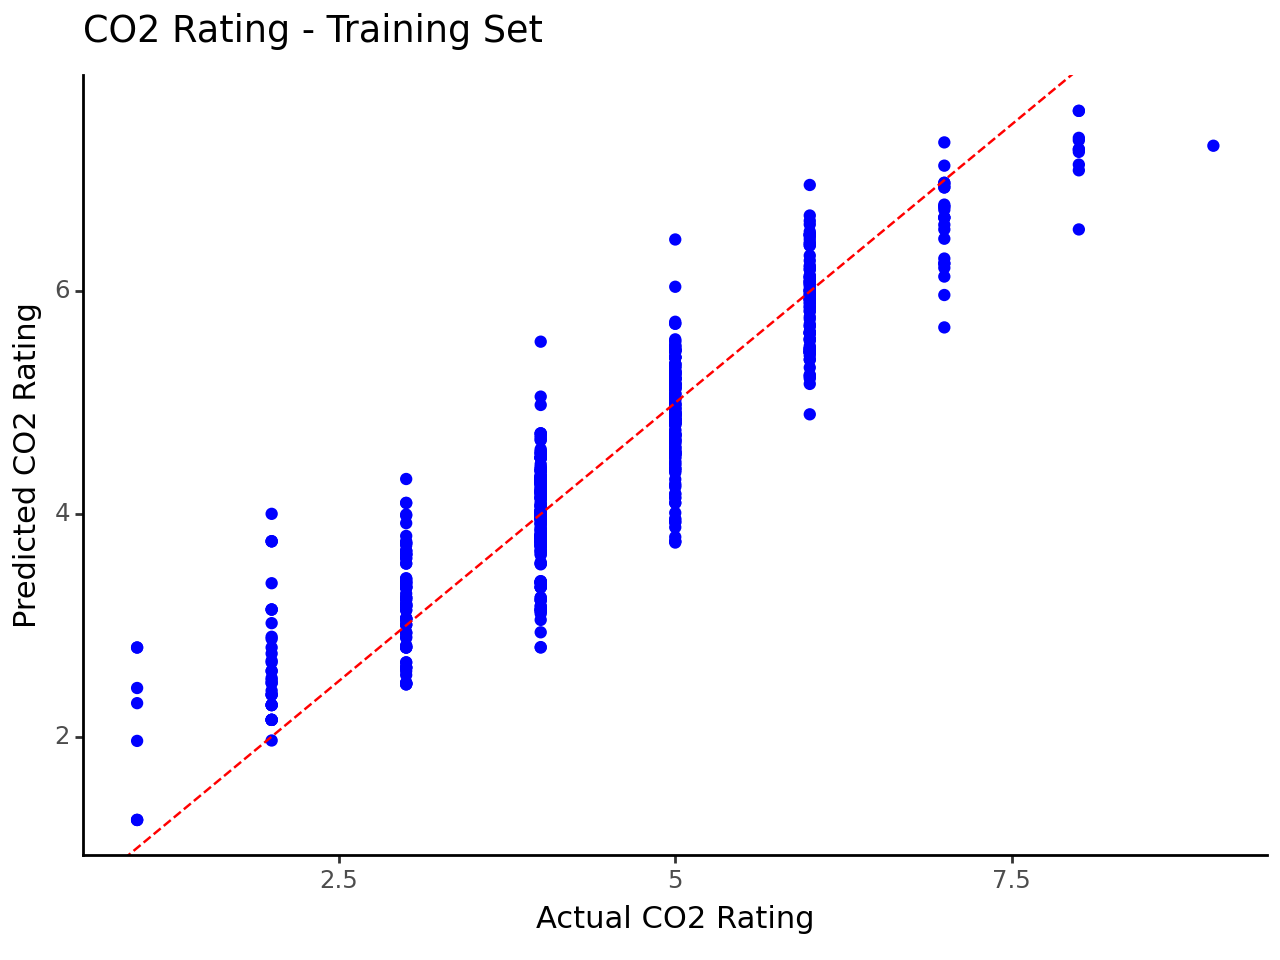

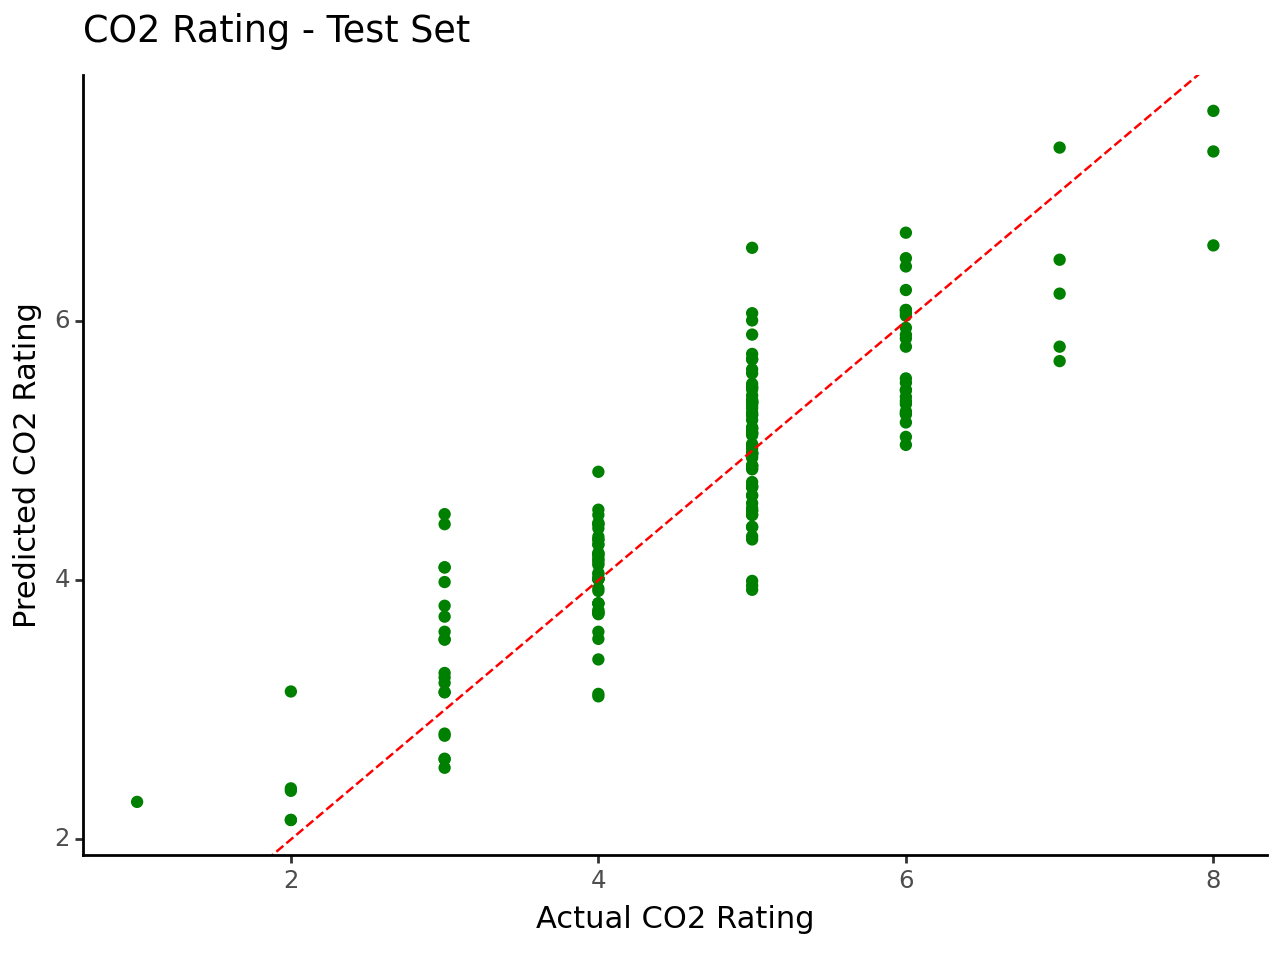

In [ ]:
#Convert arrays to DataFrame
df_train = pd.DataFrame({'y_train': y_trainco2, 'y_pred_train_lin': y_pred_train_lina})

print(ggplot(df_train, aes(x = "y_train", y = "y_pred_train_lin")) +
             geom_point(color='blue') +
             geom_abline(intercept=0, slope=1, linetype='dashed', color='red') +
             theme_classic() +
             labs(x='Actual CO2 Rating', y='Predicted CO2 Rating') +
             ggtitle('CO2 Rating - Training Set'))
df_test = pd.DataFrame({'y_test': y_testco2, 'y_pred_test_lin': y_pred_test_lina})
print(ggplot(df_test, aes(x = "y_test", y = "y_pred_test_lin")) +
                 geom_point(color = 'green') +
                 geom_abline(intercept=0, slope=1, linetype='dashed', color='red') +
                 theme_classic() +
                 labs(x='Actual CO2 Rating', y='Predicted CO2 Rating') +
                 ggtitle('CO2 Rating - Test Set'))

In [ ]:
#set up X and y
predictors = ["Year", "Make", "Vehicle Class", "Engine Size (L)",
              "Cylinders", "Transmission", "Fuel Type"]


X8 = data[predictors]
y8 = data["Smog Rating"]

# validation
X_train, X_test, y_trainsmog, y_testsmog = train_test_split(X8,y8, test_size = 0.2, random_state = 42)

# z score
preprocess = make_column_transformer((OneHotEncoder(), ["Year", "Make", "Vehicle Class", "Engine Size (L)",
              "Cylinders", "Transmission", "Fuel Type"]),
                                                                   remainder = "passthrough")
#LASSO
lr = LassoCV()

pipe = Pipeline([("pre", preprocess),
                ("lasso", lr)])

# fit
pipe.fit(X_train,y_trainsmog)

# predict
y_pred_train_lin = pipe.predict(X_train)
y_pred_test_lin = pipe.predict(X_test)


#asses
print("Linear Regression: ")
print("Train MSE : ", mean_squared_error(y_trainsmog,y_pred_train_lin))
print("Train MAE : ", mean_absolute_error(y_trainsmog,y_pred_train_lin))
print("Train MAPE: ", mean_absolute_percentage_error(y_trainsmog,y_pred_train_lin))
print("Train R2  : ", r2_score(y_trainsmog,y_pred_train_lin))

print("Test MSE : ", mean_squared_error(y_testsmog,y_pred_test_lin))
print("Test MAE : ", mean_absolute_error(y_testsmog,y_pred_test_lin))
print("Test MAPE: ", mean_absolute_percentage_error(y_testsmog,y_pred_test_lin))
print("Test R2  : ", r2_score(y_testsmog,y_pred_test_lin))

Linear Regression: 
Train MSE :  0.668649041249052
Train MAE :  0.6050682187706935
Train MAPE:  0.15723937082223247
Train R2  :  0.7679129897477931
Test MSE :  0.8764717942973959
Test MAE :  0.7280301410391286
Test MAPE:  0.1689799650313123
Test R2  :  0.6240437744753748


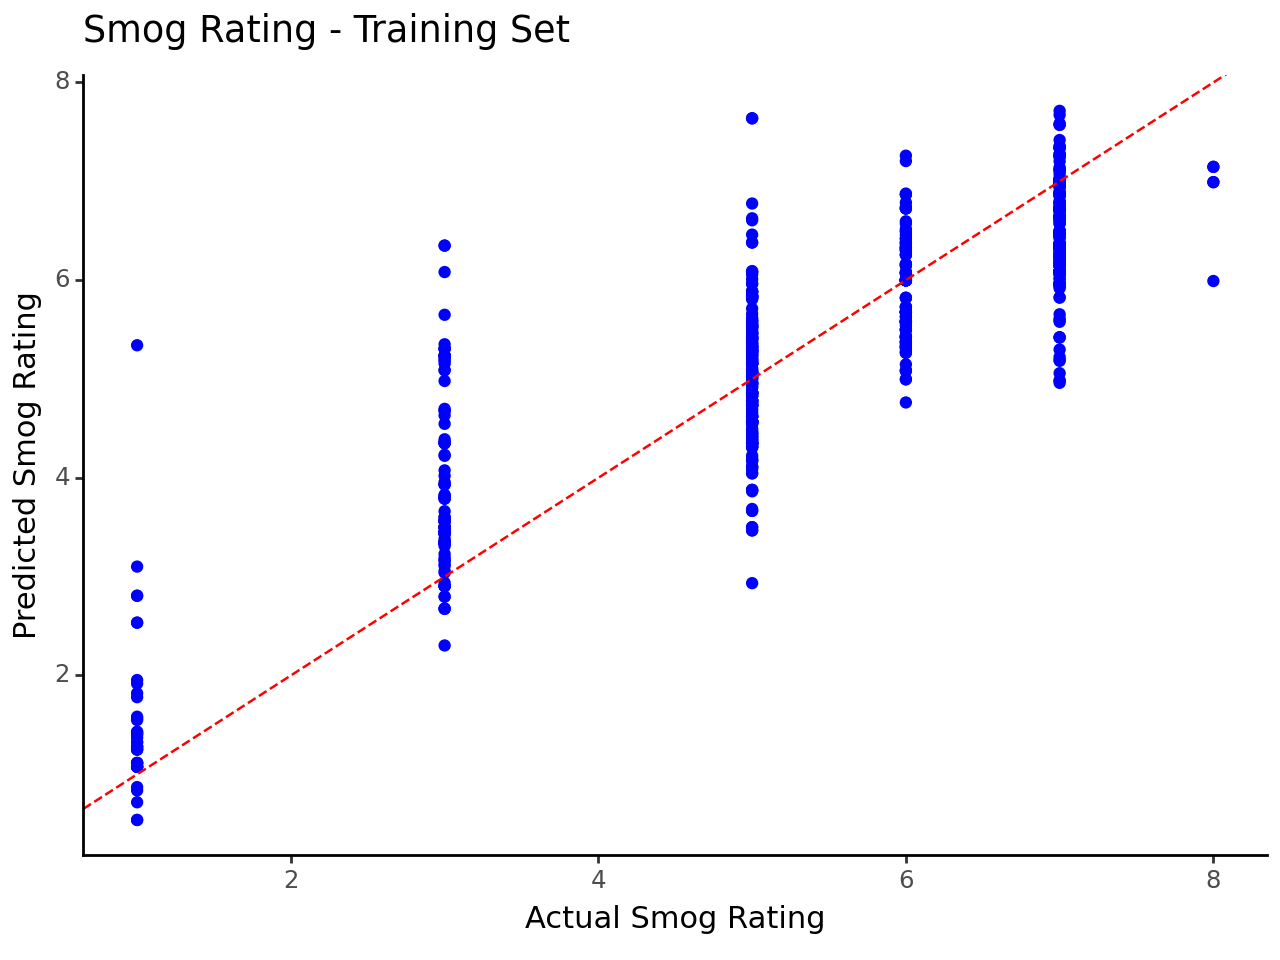

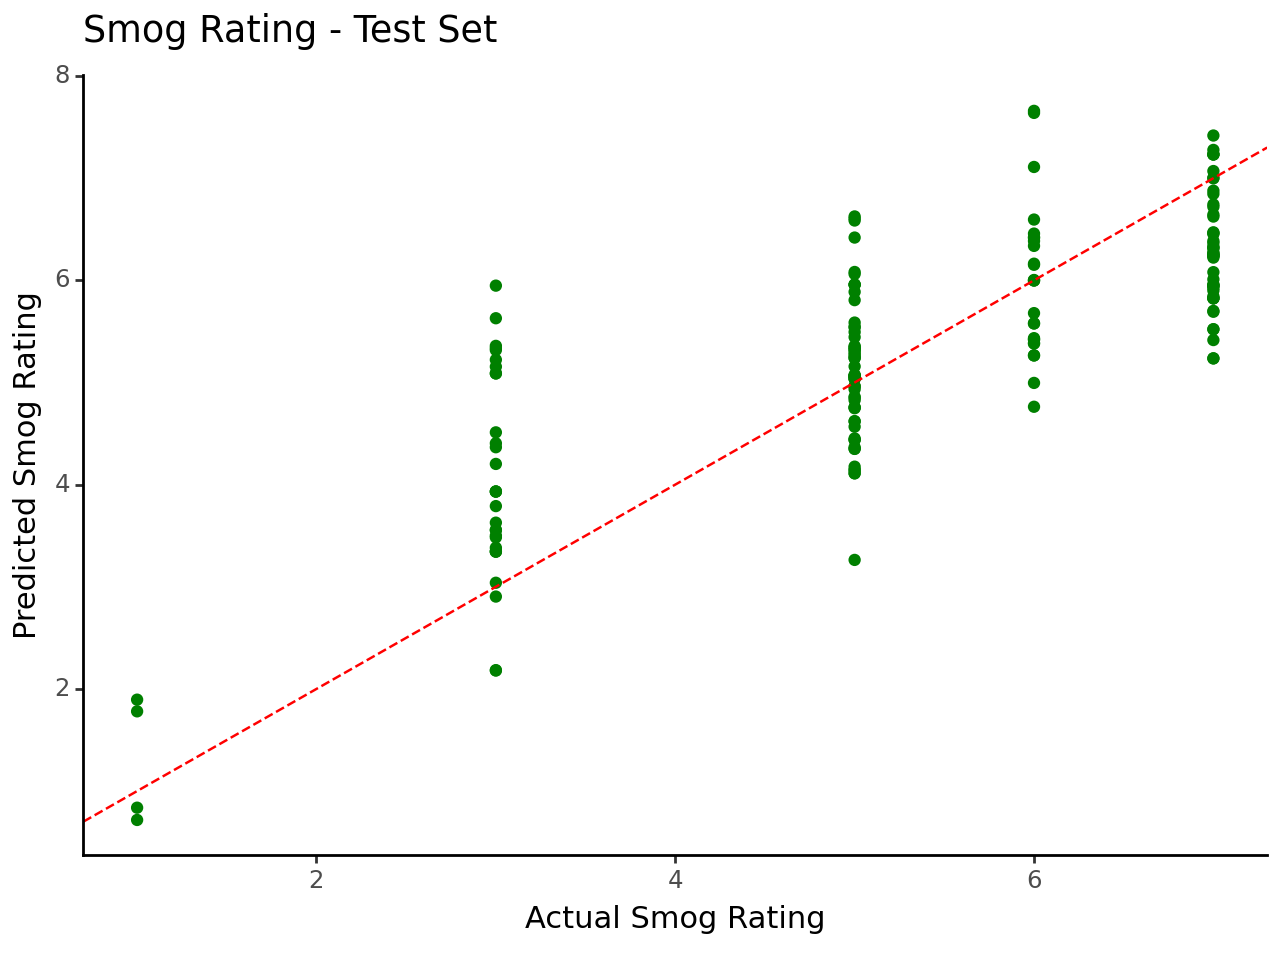

In [ ]:
#Convert arrays to DataFrame
df_train_smog = pd.DataFrame({'y_train': y_trainsmog, 'y_pred_train_lin': y_pred_train_lin})

# Scatter plot for Smog rating
print(ggplot(df_train_smog, aes(x='y_train', y='y_pred_train_lin')) +
              geom_point(color='blue') +
              geom_abline(intercept=0, slope=1, linetype='dashed', color='red') +
              theme_classic() +
              labs(x='Actual Smog Rating', y='Predicted Smog Rating') +
              ggtitle('Smog Rating - Training Set'))
df_test_smog = pd.DataFrame({'y_test': y_testsmog, 'y_pred_test_lin': y_pred_test_lin})
print(ggplot(df_test_smog, aes(x='y_test', y='y_pred_test_lin')) +
                  geom_point(color='green') +
                  geom_abline(intercept=0, slope=1, linetype='dashed', color='red') +
                  theme_classic() +
                  labs(x='Actual Smog Rating', y='Predicted Smog Rating') +
                  ggtitle('Smog Rating - Test Set'))